In [1]:
from pathlib import Path
import numpy as np
import os
import shutil
# run adversarial that trained with ladder training

models = {
    "ladder" : Path("/home/isaacp/sharedrepos/IsaacLab-HARL/scripts/reinforcement_learning/harl/"+
                  "results/isaaclab/leatherback-Sumo-Direct-MA-Stage2-v0/happo_adv/"+
                  "leatherback_ladder_training/seed-00001-2025-08-29-15-44-20/models/checkpoints"),
    "leapfrog" : Path("/home/isaacp/sharedrepos/IsaacLab-HARL/scripts/reinforcement_learning/"+
                "harl/results/isaaclab/leatherback-Sumo-Direct-MA-Stage2-v0/happo_adv/"+
                "leatherback_leapfrog_training/seed-00001-2025-08-29-22-27-04/models/checkpoints"),
    "parallel" : Path("/home/isaacp/sharedrepos/IsaacLab-HARL/scripts/reinforcement_learning/harl"+
                "/results/isaaclab/leatherback-Sumo-Direct-MA-Stage2-v0/happo_adv/"+
                "leatherback_parallel_training/seed-00001-2025-08-29-19-06-53/models/checkpoints")
}

checkpoint_1_folder="episode_1"
results = {}

try:
    for key, models_dir in models.items():
        for curr_folder in sorted(os.listdir(models_dir),
                                key=lambda x: int(x.split("_")[-1]) if "episode" in x else -1):
            if "episode" in curr_folder:
                episode_num = int(curr_folder.split("_")[-1])
                if "episode_num" not in results:
                    results["episode_num"] = {}
                if key not in results["episode_num"]:
                    results["episode_num"][key] = []
                results["episode_num"][key].append(episode_num)

                checkpoint_1_path=models_dir / checkpoint_1_folder
                curr_checkpoint_path=models_dir / curr_folder

                new_checkpoint_path = models_dir / "curr_checkpoint"

                # we take the policies from the first checkpoint and compare them against the current policies
                os.makedirs(new_checkpoint_path, exist_ok=True)
                shutil.copy(checkpoint_1_path / "actor_agent_robot_2.pt", new_checkpoint_path / "actor_agent_robot_2.pt")
                shutil.copy(checkpoint_1_path / "actor_agent_robot_3.pt", new_checkpoint_path / "actor_agent_robot_3.pt")
                shutil.copy(curr_checkpoint_path / "actor_agent_robot_0.pt", new_checkpoint_path / "actor_agent_robot_0.pt")
                shutil.copy(curr_checkpoint_path / "actor_agent_robot_1.pt", new_checkpoint_path / "actor_agent_robot_1.pt")

                npz_save_path = "./ladder_training_results.npz"

                !python ./get_adversarial_results.py \
                    --num_envs 100 \
                    --algo "happo_adv" \
                    --task "leatherback-Sumo-Direct-MA-Stage2-v0" \
                    --seed 1 \
                    --num_env_steps 3_100_000 \
                    --dir {new_checkpoint_path} \
                    --save_path {npz_save_path} \
                    --debug \
                    --headless

                res = np.load(npz_save_path)
                for k, v in res.items():
                    if k not in results:
                        results[k] = {}
                    if key not in results[k]:
                        results[k][key] = []
                    results[k][key].append(v.item())
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    if 'new_checkpoint_path' in locals() and os.path.exists(new_checkpoint_path):
        shutil.rmtree(new_checkpoint_path)
    if 'npz_save_path' in locals() and os.path.exists(npz_save_path):
        os.remove(npz_save_path)

[INFO][AppLauncher]: Using device: cuda:0
[INFO][AppLauncher]: Loading experience file: /home/isaacp/sharedrepos/IsaacLab-HARL/apps/isaaclab.python.headless.kit
[Warning] [simulation_app.simulation_app] Modules: ['omni.kit_app'] were loaded before SimulationApp was started and might not be loaded correctly.
[Warning] [simulation_app.simulation_app] Please check to make sure no extra omniverse or pxr modules are imported before the call to SimulationApp(...)
Loading user config located at: '/home/isaacp/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/omni/data/Kit/Isaac-Sim/4.5/user.config.json'
[Info] [carb] Logging to file: /home/isaacp/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/omni/logs/Kit/Isaac-Sim/4.5/kit_20250902_172113.log
2025-09-02 23:21:13 s] [Warning] [omni.kit.app.plugin] No crash reporter present, dumps uploading isn't available.
2025-09-02 23:21:13 s] [Warning] [omni.ext.plugin] [ext: rendering_modes] Extensions config 'extension.toml' doesn't ex

In [2]:
results.keys()

dict_keys([])

In [3]:
import pickle

pickle.dump(results, open("leatherback_paper_results.pkl", "wb"))

In [6]:
res = pickle.load(open("leatherback_paper_results.pkl", "rb"))
res['episode_num'].keys()

dict_keys(['ladder', 'leapfrog', 'parallel'])

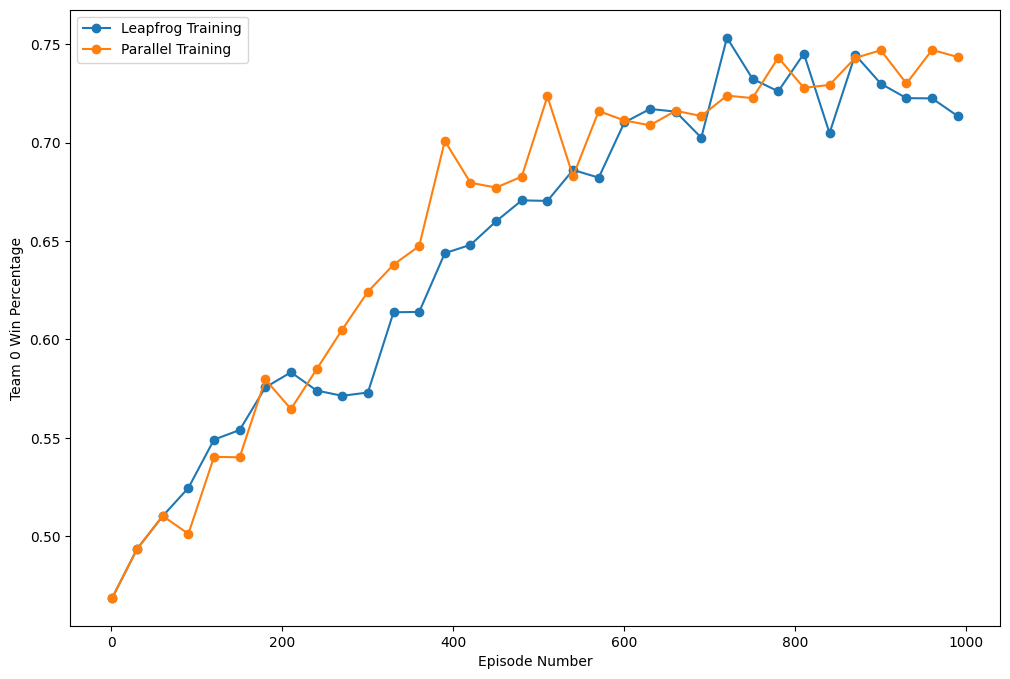

In [21]:
import matplotlib.pyplot as plt

    

plt.figure(figsize=(12, 8))
# plt.plot(results["episode_num"]["ladder"], results["team0_win_percentage"]["ladder"], marker='o', label='Ladder Training')
plt.plot(results["episode_num"]["leapfrog"], results["team0_win_percentage"]["leapfrog"], marker='o', label='Leapfrog Training')
plt.plot(results["episode_num"]["parallel"], results["team0_win_percentage"]["parallel"], marker='o', label='Parallel Training')
plt.xlabel("Episode Number")
plt.ylabel("Team 0 Win Percentage")
plt.legend()
plt.show()